# Part 6 - Supervised Learning

My intuition is that this will be best classified with a non-linear algorithm, but I'll try logistic regression first

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer




from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer




from sklearn.linear_model import LogisticRegression


df = pd.read_pickle('BeatlesSongsClustered.pkl')
#

In [150]:
##These facts are sorted in alphabetical order. To elminiate any potiential bias, I will shuffle the order of the facts

#I know I don't have to do this, but I'm going to do it anyway. old instincts when we had to do all of this without fancy libraries

df['random'] = np.random.rand(len(df))
df.sort_values('random', inplace=True)
df.drop('random', axis=1, inplace=True)

# Reset the index
df.reset_index(drop=True, inplace=True)
             

In [128]:
df.dtypes

Id                                      int64
SongKey                                object
song                                   object
songwriters                            object
lead_vocals                            object
year                                    int32
cover                                   int64
Era                                    object
first_release_date             datetime64[ns]
max_key                               float64
mode                                  float64
avg_danceability                      float64
avg_energy                            float64
avg_loudness                          float64
avg_speechiness                       float64
avg_acousticness                      float64
avg_instrumentalness                  float64
avg_liveness                          float64
avg_valence                           float64
avg_tempo                             float64
avg_duration_ms                       float64
avg_time_signature                

In [129]:
#This number will be important for comparison purposes after I encode categorical variables
df.shape
#(196, 61)

(196, 61)

## First Pass will be a conventional logistic regression

In [130]:
### I'l start with reading in the numeric and categorical features. There are a few features (key, mode) that appear numeric but are actually categorical



# Selecting only numeric features
num_features = ['year', 'avg_danceability', 'avg_energy', 'avg_loudness', 'avg_speechiness', 
                'avg_acousticness', 'avg_instrumentalness', 'avg_liveness', 'avg_valence', 
                'avg_tempo', 'avg_duration_ms', 'avg_time_signature', 'avg_popularity', 
                'BB_peak_position', 'BB_weeks_on_chart',
                'RobSegment', 'LauraSegment', 'EmilySegment', 'OliviaSegment', 
                'BrianSegment', 'JackieSegment']


cat_features = ['Era', 'mode', 'keyname', 'Cluster_Name',  'BB_peak_position','RollingStonePosition']
                

##This is just a handy reference or could be useful if I want to do some more feature engineering
excluded_features = ['Id', 'SongKey', 'song', 'songwriters', 'lead_vocals', 'cover',
                     'first_release_date', 'max_key', 'Song_y', 'lyrics', 
                     'core_catalogue_releases', 'Canonical_album', 'first_vocalist',
                     ###'Paul_Song', 
                     'John_Song', 'George_Song', 'Ringo_Song', 'popularity', 
                     'BB_name', 'BB_artist', 'BB_debut_date', 'BB_peak_date', 
                     'distilbertsentiment', 'FinetunedSentiment_Negative', 
                     'FinetunedSentiment_Positive', 'cluster', 'vader_neg', 'vader_neu',
                     'vader_pos', 'vader_compound', 'roberta_neg', 'roberta_neu', 
                     'roberta_pos', 'Pipeline_sentiment_label', 'Pipeline_sentiment_score']



In [90]:
##This is first pass using the LabelEncoder utility function

# Instantiate the LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder on each of the categorical variables:
for column in cat_features:
    df[column] = le.fit_transform(df[column])



In [91]:
#df.shape
#(196, 61)
print(df['Cluster_Name'].value_counts())


3    42
4    39
1    31
0    30
6    24
2    19
5    11
Name: Cluster_Name, dtype: int64


In [131]:
##check out One Hot Encoder for this application
from sklearn.preprocessing import OneHotEncoder

# Instantiate the OneHotEncoder
ohe = OneHotEncoder()

# Apply OneHotEncoder on each of the categorical variables:
df_encoded = pd.get_dummies(df, columns=cat_features)


In [122]:
df_encoded.dtypes

Id                                              int64
SongKey                                        object
song                                           object
songwriters                                    object
lead_vocals                                    object
year                                            int32
cover                                           int64
first_release_date                     datetime64[ns]
max_key                                       float64
avg_danceability                              float64
avg_energy                                    float64
avg_loudness                                  float64
avg_speechiness                               float64
avg_acousticness                              float64
avg_instrumentalness                          float64
avg_liveness                                  float64
avg_valence                                   float64
avg_tempo                                     float64
avg_duration_ms             

##### Note important change in shape from using OHE. Whereas OHE creates a new column for EACH individual value embedded within a categorical variable, LabelEncoder just creates a new column for each categorical variable

In [132]:
#This is number of columns from my pre-pre-processing df.
df.shape
#(196, 61)

#This is the number of columns after OHE creates all those dummy values df.
df_encoded.shape
##(196, 149)


(196, 133)

In [95]:
df_encoded.dtypes

Id                                      int64
SongKey                                object
song                                   object
songwriters                            object
lead_vocals                            object
year                                    int32
cover                                   int64
first_release_date             datetime64[ns]
max_key                               float64
avg_danceability                      float64
avg_energy                            float64
avg_loudness                          float64
avg_speechiness                       float64
avg_acousticness                      float64
avg_instrumentalness                  float64
avg_liveness                          float64
avg_valence                           float64
avg_tempo                             float64
avg_duration_ms                       float64
avg_time_signature                    float64
Song_y                                 object
lyrics                            

In [133]:
# Iteration 1: My numerical features now include the one-hot encoded categorical variables

##Dropping one of the dummy variables in each encoding to avoid multicollinearity
## THis is to avoid the "encoder trap"

# Define a list of column names to be dropped
# Define a list of column names to be removed
remove_columns = ['Era_0', 'mode_0', 'keyname_0', 'Cluster_Name_0', 'BB_peak_position_0', 'RollingStonePosition_0']

num_features = ['year', 'avg_danceability', 'avg_energy', 'avg_loudness', 'avg_speechiness', 
                'avg_acousticness', 'avg_instrumentalness', 'avg_liveness', 'avg_valence', 
                'avg_tempo', 'avg_duration_ms', 'avg_time_signature', 'avg_popularity', 
                'BB_weeks_on_chart'] + \
               [col for col in df_encoded.columns if col.startswith(('Era_', 'mode_', 'keyname_', 'Cluster_Name_', 
                                                              'RobSegment_', 'LauraSegment_', 'EmilySegment_', 
                                                              'OliviaSegment_', 'BrianSegment_', 'JackieSegment_', 
                                                              'BB_peak_position_', 'RollingStonePosition_'))
                and col not in remove_columns]


# No more categorical features to process since they are all one-hot encoded
# again, this is not needed but a good reminder
cat_features = []

#The target variable for this exercise is 'Paul_Song' This is a binomial variable with 0 = not a Paul song and 1 = Paul song. 
target_feature = df['Paul_Song']
## target_feature.value_counts()
## 0    127
## 1     69
## Name: Paul_Song, dtype: int64


##Assign the 'X' (independent) and 'y' (dependent) variables
X = df_encoded[num_features]
y = df['Paul_Song']

# Train-Test Split for 20% holdout
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.columns


Index(['year', 'avg_danceability', 'avg_energy', 'avg_loudness',
       'avg_speechiness', 'avg_acousticness', 'avg_instrumentalness',
       'avg_liveness', 'avg_valence', 'avg_tempo', 'avg_duration_ms',
       'avg_time_signature', 'avg_popularity', 'BB_weeks_on_chart',
       'Era_Beatlemania', 'Era_Experimental', 'Era_Group of Solo Artists',
       'mode_0.0', 'mode_1.0', 'keyname_A', 'keyname_A#/Bb', 'keyname_B',
       'keyname_C', 'keyname_C#/Db', 'keyname_D', 'keyname_D#/Eb', 'keyname_E',
       'keyname_F', 'keyname_F#/Gb', 'keyname_G', 'keyname_G#/Ab',
       'Cluster_Name_Acoustic Beauty', 'Cluster_Name_Angsty',
       'Cluster_Name_Early Covers', 'Cluster_Name_Eclectic Experiments',
       'Cluster_Name_Fab Four', 'Cluster_Name_Magical Musings',
       'Cluster_Name_Psychedelic Soundscape', 'BB_peak_position_2',
       'BB_peak_position_3', 'BB_peak_position_4', 'BB_peak_position_5',
       'BB_peak_position_7', 'BB_peak_position_8', 'BB_peak_position_11',
       'BB_peak_p

In [135]:
## Iteration 2:
# My numerical features now include the one-hot encoded categorical variables
num_features = ['avg_danceability', 'avg_energy', 'avg_loudness', 'avg_speechiness', 
                'avg_acousticness', 'avg_instrumentalness', 'avg_liveness', 'avg_valence', 
                'avg_tempo', 'avg_duration_ms', 'avg_time_signature', 'avg_popularity'] + \
               [col for col in df_encoded.columns if col.startswith(('Era_', 'mode_', 'keyname_',
                                                              'RobSegment_', 'LauraSegment_', 'EmilySegment_', 
                                                              'OliviaSegment_', 'BrianSegment_', 'JackieSegment_'
                                                             ))
                and col not in remove_columns]


##Cluster name is a function of the following: 'year', 'avg_danceability', 'avg_energy', 'avg_loudness', 'avg_speechiness', 'avg_acousticness', 'avg_instrumentalness', 'avg_liveness', 
##             'avg_valence', 'avg_tempo', 'avg_duration_ms', 'avg_time_signature', 'avg_popularity', 'Paul_Song', 'John_Song', 'George_Song',  
##             'BB_weeks_on_chart',	'RollingStonePosition', 'FinetunedSentiment_Positive', 'cover']

## dropping year because I believe Era is more important
## dropping 'Cluster_Name_' because many of the values that went into the K-Means clustering are already in the model elsewhere.
## dropping measures of popularity, except avg_popularity from Spotify. 'BB_peak_position_', 'RollingStonePosition_'
## leaving in Segments because 



##Assign the 'X' (independent) and 'y' (dependent) variables
X = df_encoded[num_features]
y = df['Paul_Song']

# Train-Test Split for 20% holdout
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.columns

Index(['avg_danceability', 'avg_energy', 'avg_loudness', 'avg_speechiness',
       'avg_acousticness', 'avg_instrumentalness', 'avg_liveness',
       'avg_valence', 'avg_tempo', 'avg_duration_ms', 'avg_time_signature',
       'avg_popularity', 'Era_Beatlemania', 'Era_Experimental',
       'Era_Group of Solo Artists', 'mode_0.0', 'mode_1.0', 'keyname_A',
       'keyname_A#/Bb', 'keyname_B', 'keyname_C', 'keyname_C#/Db', 'keyname_D',
       'keyname_D#/Eb', 'keyname_E', 'keyname_F', 'keyname_F#/Gb', 'keyname_G',
       'keyname_G#/Ab'],
      dtype='object')

In [137]:
## Iteration 3:
# My numerical features now include the one-hot encoded categorical variables
num_features = ['avg_danceability', 'avg_energy', 'avg_loudness', 'avg_speechiness', 
                'avg_acousticness', 'avg_instrumentalness', 'avg_liveness', 'avg_valence', 
                'avg_tempo', 'avg_duration_ms', 'avg_time_signature', 'avg_popularity'] + \
               [col for col in df_encoded.columns if col.startswith(('Era_', 'mode_', 'keyname_' ))
                and col not in remove_columns]

#In addition to the above, I am adding the removing features from Segments.


##Assign the 'X' (independent) and 'y' (dependent) variables
X = df_encoded[num_features]
y = df['Paul_Song']

# Train-Test Split for 20% holdout
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.columns


Index(['avg_danceability', 'avg_energy', 'avg_loudness', 'avg_speechiness',
       'avg_acousticness', 'avg_instrumentalness', 'avg_liveness',
       'avg_valence', 'avg_tempo', 'avg_duration_ms', 'avg_time_signature',
       'avg_popularity', 'Era_Beatlemania', 'Era_Experimental',
       'Era_Group of Solo Artists', 'mode_0.0', 'mode_1.0', 'keyname_A',
       'keyname_A#/Bb', 'keyname_B', 'keyname_C', 'keyname_C#/Db', 'keyname_D',
       'keyname_D#/Eb', 'keyname_E', 'keyname_F', 'keyname_F#/Gb', 'keyname_G',
       'keyname_G#/Ab'],
      dtype='object')

# Just run the thing already!

In [138]:
# Define the preprocessing for numeric columns (scale them)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Bundle preprocessing for numeric data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features)])

# Create a pipeline that combines the preprocessor with the estimator
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', LogisticRegression())])

# Train the model
pipe.fit(X_train, y_train)

# Get the prediction
y_pred = pipe.predict(X_test)

# Checking accuracy
print("Training Score: {}".format(pipe.score(X_train, y_train)))
print("Testing Score: {}".format(pipe.score(X_test, y_test)))




##Uh oh, I've overfit the model. I'll try a few different things to see if I can improve the model.

## Iteration 1 - ##Training Score: 0.8461538461538461 ##Testing Score: 0.55
## no better than a coin flip. I'll try a few different things to see if I can improve the model.
## Once I removed the 0th iteratioon of each encoded categorical variable, I got a Training Score:Training Score: 0.8141025641025641 Testing Score: 0.675
 #Still overfit, but right 2/3 of the time.

## Iteration 2 - Training Score: 0.7564102564102564 Testing Score: 0.625

## Iteration 3 - Training Score: 0.76 Testing Score: 0.65 - no change! The columns I removed were not important.


Training Score: 0.75
Testing Score: 0.6


In [139]:
## do internal diagnostics to see if I can improve the model

from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, confusion_matrix

# Precision, Recall, F1 Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

# Area Under the ROC Curve (AUC-ROC)
y_pred_proba = pipe.predict_proba(X_test)[:, 1]  # Predict probabilities for positive class
auc_roc = roc_auc_score(y_test, y_pred_proba)

print("AUC-ROC: {:.2f}".format(auc_roc))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Feature Importance
logreg = pipe.named_steps['classifier']
feature_names = pipe.named_steps['preprocessor'].transformers_[0][2]

coefficients = logreg.coef_[0]
feature_importance = dict(zip(feature_names, coefficients))

# Sort feature importance in descending order
sorted_importance = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)

# Print feature importance
for feature, importance in sorted_importance:
    print("{}: {:.4f}".format(feature, importance))



Precision: 0.50
Recall: 0.25
F1 Score: 0.33
AUC-ROC: 0.59
Confusion Matrix:
 [[20  4]
 [12  4]]
avg_loudness: 0.6126
keyname_F#/Gb: -0.5557
avg_danceability: 0.5420
avg_acousticness: 0.4411
avg_energy: -0.3667
avg_liveness: 0.3228
Era_Beatlemania: -0.3058
keyname_F: 0.3006
avg_instrumentalness: 0.2815
Era_Group of Solo Artists: 0.2605
avg_valence: -0.2269
avg_tempo: -0.2189
avg_popularity: 0.2058
avg_speechiness: -0.1946
keyname_A#/Bb: 0.1922
keyname_G#/Ab: 0.1291
avg_duration_ms: -0.1221
keyname_B: -0.1168
Era_Experimental: 0.1099
keyname_G: 0.1031
keyname_A: -0.0927
mode_1.0: 0.0854
mode_0.0: -0.0854
keyname_E: 0.0826
keyname_C: -0.0806
keyname_C#/Db: 0.0668
keyname_D: -0.0410
keyname_D#/Eb: -0.0231
avg_time_signature: 0.0143


In [115]:
# Define confusion matrix values
TN = 23
FP = 4
FN = 11
TP = 2

# Calculate and print False Positive Rate
FPR = FP / (FP + TN)
print(f"False Positive Rate: {FPR * 100:.2f}%")

# Calculate and print False Negative Rate
FNR = FN / (FN + TP)
print(f"False Negative Rate: {FNR * 100:.2f}%")

False Positive Rate: 14.81%
False Negative Rate: 84.62%


In [16]:
#!pip install statsmodels

                                              0.0/9.2 MB ? eta -:--:--
                                              0.1/9.2 MB 2.0 MB/s eta 0:00:05
                                              0.2/9.2 MB 1.5 MB/s eta 0:00:06
     -                                        0.2/9.2 MB 1.6 MB/s eta 0:00:06
     -                                        0.3/9.2 MB 1.8 MB/s eta 0:00:06
     -                                        0.4/9.2 MB 1.8 MB/s eta 0:00:05
     --                                       0.5/9.2 MB 1.9 MB/s eta 0:00:05
     --                                       0.7/9.2 MB 2.0 MB/s eta 0:00:05
     ---                                      0.8/9.2 MB 2.0 MB/s eta 0:00:05
     ---                                      0.9/9.2 MB 2.0 MB/s eta 0:00:05
     ----                                     1.0/9.2 MB 2.1 MB/s eta 0:00:04
     ----                                     1.1/9.2 MB 2.1 MB/s eta 0:00:04
     -----                                    1.2/9.2 MB 2.2 MB/s eta 0

In [140]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin

# Define a class for the Variance Inflation Factor
class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        if impute:
            self.imputer = SimpleImputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

# Define the preprocessing for numeric columns (scale them)
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Bundle preprocessing for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features)])

# Create a pipeline that combines the preprocessor with the estimator
pipe = Pipeline(steps=[('reduce_vif', ReduceVIF()), 
                       ('preprocessor', preprocessor),
                       ('classifier', LogisticRegression())])

# Train the model
pipe.fit(X_train, y_train)

# Get the prediction
y_pred = pipe.predict(X_test)

# Checking accuracy
print("Training Score: {}".format(pipe.score(X_train, y_train)))
print("Testing Score: {}".format(pipe.score(X_test, y_test)))


ReduceVIF fit
ReduceVIF transform
Dropping Era_Beatlemania with vif=inf
Dropping mode_0.0 with vif=inf
Dropping keyname_A with vif=136.90246542856337
Dropping avg_time_signature with vif=121.26799187734603
Dropping avg_tempo with vif=42.51196168243863
Dropping avg_loudness with vif=35.105449060477014
Dropping avg_danceability with vif=27.530033204027312
Dropping avg_popularity with vif=24.14787268473177
Dropping avg_energy with vif=22.291631894372834
Dropping mode_1.0 with vif=13.227171861162711
Dropping avg_duration_ms with vif=8.205688234749275
Dropping avg_valence with vif=6.6645986478686625
Dropping avg_speechiness with vif=5.011176105778651


c:\Users\rob\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\rob\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


ValueError: A given column is not a column of the dataframe

Mean Squared Error: 0.2524898650298959
Lasso picked 3 variables and eliminated the other 26 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

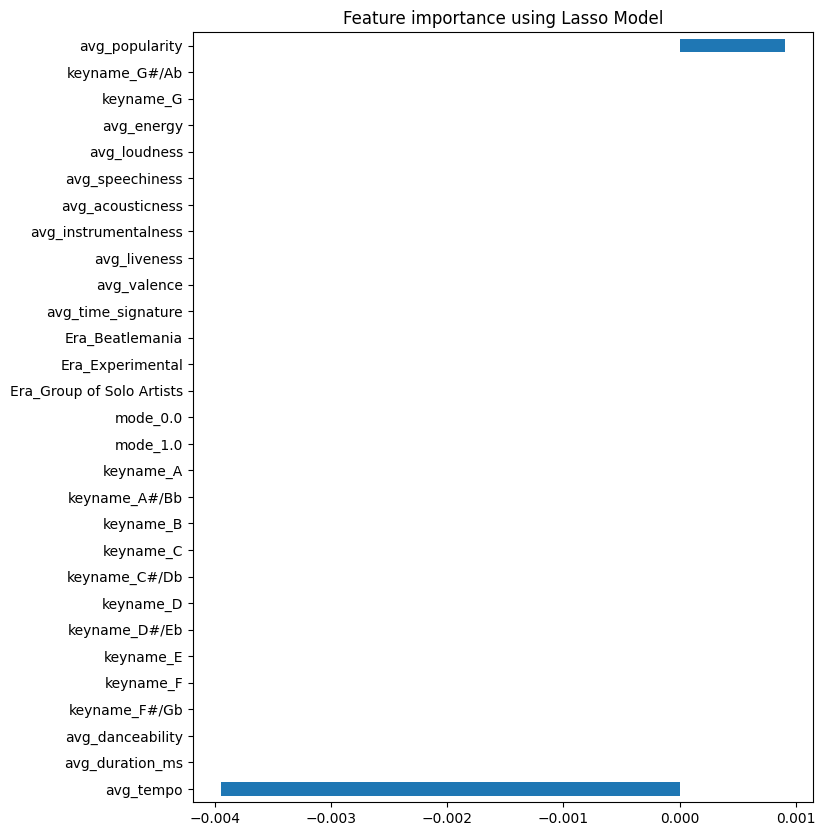

In [142]:
##implement lasso (linear) regression to see if I can improve the model

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Specify features and target variable
features = ['avg_danceability', 'avg_energy', 'avg_loudness', 'avg_speechiness', 'avg_acousticness',
            'avg_instrumentalness', 'avg_liveness', 'avg_valence', 'avg_tempo', 'avg_duration_ms',
            'avg_time_signature', 'avg_popularity', 'Era_Beatlemania', 'Era_Experimental',
            'Era_Group of Solo Artists', 'mode_0.0', 'mode_1.0', 'keyname_A', 'keyname_A#/Bb',
            'keyname_B', 'keyname_C', 'keyname_C#/Db', 'keyname_D', 'keyname_D#/Eb', 'keyname_E',
            'keyname_F', 'keyname_F#/Gb', 'keyname_G', 'keyname_G#/Ab']

# Assuming 'y' is your target variable
X = df_encoded[num_features]
y = df['Paul_Song']


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Lasso model (you can change the alpha value to adjust the amount of penalization)
lasso = Lasso(alpha=0.1)

# Fit the model to the training data
lasso.fit(X_train, y_train)

# Use the model to predict the test set
y_pred = lasso.predict(X_test)

# Calculate and print the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Get the model coefficients
coef = pd.Series(lasso.coef_, index = X.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define your features and target variable
X = df_encoded[num_features]
y = df['Paul_Song']


# Split the dataset into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# It's good practice to scale your data for logistic regression
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize Logistic Regression with L1 regularization (Lasso)
lasso_logistic = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
lasso_logistic.fit(X_train, y_train)
y_pred_lasso = lasso_logistic.predict(X_test)

# Initialize Logistic Regression with L2 regularization (Ridge)
ridge_logistic = LogisticRegression(penalty='l2', solver='liblinear', C=1.0)
ridge_logistic.fit(X_train, y_train)
y_pred_ridge = ridge_logistic.predict(X_test)


In [145]:
## using L1 regularization (Lasso) to see if I can improve the model

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming 'y' is your binary target variable and X is your feature matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lasso Logistic Regression
lasso_logistic = LogisticRegression(penalty='l1', solver='liblinear')

# Fit the model
lasso_logistic.fit(X_train, y_train)

# Predict on the test data
y_pred = lasso_logistic.predict(X_test)

# Get the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.675


In [146]:
## using L2 regularization (Ridge) to see if I can improve the model

# Ridge Logistic Regression
ridge_logistic = LogisticRegression(penalty='l2')

# Fit the model
ridge_logistic.fit(X_train, y_train)

# Predict on the test data
y_pred = ridge_logistic.predict(X_test)

# Get the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.575


# This is not a case for regression as a classifier


## Next step is to try a Random Forst classifier to reduce overfitting